In [479]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

# 1. Coleta de dados

In [480]:
df = pd.read_csv('https://raw.githubusercontent.com/marcelovalois/eafifa/main/FIFA-21.csv')

In [481]:
df.head()

,player_id,name,nationality,position,overall,age,hits,potential,team
0,158023,Lionel Messi,Argentina,ST|CF|RW,94,33,299,94,FC Barcelona
1,20801,Cristiano Ronaldo,Portugal,ST|LW,93,35,276,93,Juventus
2,190871,Neymar Jr,Brazil,CAM|LW,92,28,186,92,Paris Saint-Germain
3,203376,Virgil van Dijk,Netherlands,CB,91,29,127,92,Liverpool
4,200389,Jan Oblak,Slovenia,GK,91,27,47,93,Atlético Madrid


### Descrição dos dados

- player_id: o id do jogador no jogo.
- name: O nome do jogador.
- nationality: O país em que o jogador nasceu.
- position: A posição (ou posições) que o jogador atua.
- overall: A média geral do jogador no FIFA.
- age: A idade do jogador.
- potential: O potencial do jogador.
- team: O clube em que ele joga.

# 2. Pré-processamento

## Definição de tipos

In [482]:
df.dtypes

player_id       int64
name           object
nationality    object
position       object
overall         int64
age             int64
hits            int64
potential       int64
team           object
dtype: object

In [483]:
df['name'] = df['name'].astype('category')
df['nationality'] = df['nationality'].astype('category')
df['position'] = df['position'].astype('category')
df['team'] = df['team'].astype('category')

In [484]:
df.dtypes

player_id         int64
name           category
nationality    category
position       category
overall           int64
age               int64
hits              int64
potential         int64
team           category
dtype: object

## Tratamento de dados ausentes

In [485]:
df.shape

(17981, 9)

São listados os jogadores do Real Madrid com overall menor que 65, com o intuito de desconsiderar seus valores. São jogadores que abaixam o overall médio do time mas que nunca veem jogo.

In [486]:
df.loc[(df['overall'] < 65) & (df['team'] == 'Real Madrid ')]

,player_id,name,nationality,position,overall,age,hits,potential,team
13140,247411,Altube,Spain,GK,63,20,8,80,Real Madrid
13165,246606,Fran García,Spain,LB|LW,63,20,2,78,Real Madrid


In [487]:
df.loc[(df['overall'] < 65) & (df['team'] == 'Real Madrid '), ['overall']] = np.nan

In [488]:
print(df.isnull().sum())

player_id      0
name           0
nationality    0
position       0
overall        2
age            0
hits           0
potential      0
team           0
dtype: int64


É feita imputação de dados com a mediana

In [489]:
realMadridMean = df[df['team'] == 'Real Madrid ']['overall'].median()
realMadridMean

82.0

In [490]:
df['overall'].fillna(realMadridMean, inplace=True)

In [491]:
df[df['team'] == 'Real Madrid ']['overall']


7        91.0
17       89.0
18       89.0
21       89.0
26       88.0
28       88.0
31       88.0
68       86.0
94       85.0
98       85.0
109      85.0
135      84.0
151      84.0
226      82.0
229      82.0
250      82.0
277      82.0
289      82.0
316      81.0
329      81.0
469      80.0
562      79.0
735      78.0
806      78.0
2240     74.0
3358     72.0
4288     71.0
6037     69.0
9430     66.0
9448     66.0
10743    65.0
13140    82.0
13165    82.0
Name: overall, dtype: float64

## Normalização e limpeza

In [492]:
scaler = MinMaxScaler()
df['overall_norm'] = scaler.fit_transform(df[['overall']])
df['overall_norm'].describe()

count    17981.000000
mean         0.296749
std          0.155954
min          0.000000
25%          0.184211
50%          0.289474
75%          0.394737
max          1.000000
Name: overall_norm, dtype: float64

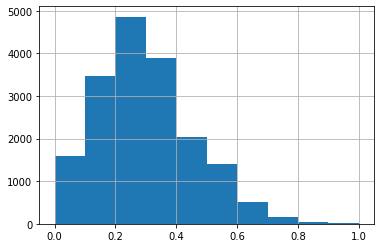

In [493]:
df['overall_norm'].hist()

In [494]:
q1 = df['overall_norm'].quantile(q=0.25)
q3 = df['overall_norm'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)

0.21052631578947367


In [495]:
df[df['overall_norm'] > (q3+1.5*iqr)]

,player_id,name,nationality,position,overall,age,hits,potential,team,overall_norm
0,158023,Lionel Messi,Argentina,ST|CF|RW,94.0,33,299,94,FC Barcelona,1.000000
1,20801,Cristiano Ronaldo,Portugal,ST|LW,93.0,35,276,93,Juventus,0.973684
2,190871,Neymar Jr,Brazil,CAM|LW,92.0,28,186,92,Paris Saint-Germain,0.947368
3,203376,Virgil van Dijk,Netherlands,CB,91.0,29,127,92,Liverpool,0.921053
4,200389,Jan Oblak,Slovenia,GK,91.0,27,47,93,Atlético Madrid,0.921053
...,...,...,...,...,...,...,...,...,...,...
218,163705,Steve Mandanda,France,GK,83.0,35,4,83,Olympique de Marseille,0.710526
219,163587,Kasper Schmeichel,Denmark,GK,83.0,33,41,83,Leicester City,0.710526
220,157481,Raúl Albiol,Spain,CB,83.0,34,7,83,Villarreal CF,0.710526
221,146562,Santi Cazorla,Spain,CDM|LM|CM,83.0,35,22,83,Villarreal CF,0.710526


## Discretização

É feita a discritização com 5 bins com mesmo intervalo

In [496]:
df['potential_dist'] = pd.cut(df['potential'], 5)

In [497]:
df['potential_dist'].value_counts()

(64.6, 72.2]      8325
(72.2, 79.8]      5832
(56.962, 64.6]    1913
(79.8, 87.4]      1788
(87.4, 95.0]       123
Name: potential_dist, dtype: int64

In [498]:
df['potential_dist'].describe()

count            17981
unique               5
top       (64.6, 72.2]
freq              8325
Name: potential_dist, dtype: object

# Projeto 2

# 1. Escolher uma das colunas para predição

Separa a coluna "hits" do dataset, que é a coluna que será realizada a predição.
Além disso, é realizado o drop das colunas "name" e "player_id", por não serem importantes para a predição.

In [499]:
x_df = df.drop(['hits', 'name', 'player_id', 'potential_dist'], axis=1)
y_df = df['hits']

x_df.head()

,nationality,position,overall,age,potential,team,overall_norm
0,Argentina,ST|CF|RW,94.0,33,94,FC Barcelona,1.000000
1,Portugal,ST|LW,93.0,35,93,Juventus,0.973684
2,Brazil,CAM|LW,92.0,28,92,Paris Saint-Germain,0.947368
3,Netherlands,CB,91.0,29,92,Liverpool,0.921053
4,Slovenia,GK,91.0,27,93,Atlético Madrid,0.921053


Algumas colunas do dataset são categóricas, logo, precisam ser transformadas em inteiro para poder fazer o modelo

In [500]:
def makeDict(uniques):
  uniques_dict = {}
  for i in range(len(uniques)):
    uniques_dict[uniques[i]] = i
  return uniques_dict

In [501]:
nationality_uniques = x_df.nationality.unique()
position_uniques = x_df.position.unique()
team_uniques = x_df.team.unique()

position_uniques_dict = makeDict(position_uniques)
team_uniques_dict = makeDict(team_uniques)
nationality_uniques_dict = makeDict(nationality_uniques)

x_df['position'] = x_df['position'].map(position_uniques_dict)
x_df['team'] = x_df['team'].map(team_uniques_dict)
x_df['nationality'] = x_df['nationality'].map(nationality_uniques_dict)

x_df = x_df.astype({'nationality': 'int64', 'position': 'int64', 'team': 'int64', 'overall': 'int64'})

x_df.head()

,nationality,position,overall,age,potential,team,overall_norm
0,0,0,94,33,94,0,1.000000
1,1,1,93,35,93,1,0.973684
2,2,2,92,28,92,2,0.947368
3,3,3,91,29,92,3,0.921053
4,4,4,91,27,93,4,0.921053


In [502]:
x_df.dtypes

nationality       int64
position          int64
overall           int64
age               int64
potential         int64
team              int64
overall_norm    float64
dtype: object

Realização do treinamento e teste:

In [503]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_df,y_df,random_state=10, test_size=0.2)

In [504]:
x_train.head()

,nationality,position,overall,age,potential,team,overall_norm
12539,44,6,64,24,71,362,0.210526
4434,39,4,71,28,74,271,0.394737
7594,33,48,68,31,68,586,0.315789
6492,35,58,69,33,69,515,0.342105
8326,98,40,67,27,68,367,0.289474


In [505]:
y_train.head()

12539    0
4434     3
7594     0
6492     1
8326     1
Name: hits, dtype: int64

In [506]:
len(x_train), len(y_train), len(x_test), len(y_test)


(14384, 14384, 3597, 3597)

In [507]:
x_train.dtypes

nationality       int64
position          int64
overall           int64
age               int64
potential         int64
team              int64
overall_norm    float64
dtype: object

# 2. Escolher 4 algoritmos para regressão

In [508]:
!pip install mlflow
import mlflow
import mlflow.sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [509]:
mlflow.sklearn.autolog()

Criar dicionário para armazenar scores:

In [510]:
scores = {}
tunned_scores = {}

## 1. Regressão Linear

In [511]:
from sklearn.linear_model import LinearRegression

algoritmo1 = LinearRegression()

with mlflow.start_run() as run1:
  algoritmo1.fit(x_train, y_train)
  print("Data in run {}".format(run1.info.run_id))

y_pred1 = algoritmo1.predict(x_test)

2022/10/04 02:37:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Data in run cae2a1aa4bd34f9ca5ba76b739026148


In [512]:
from sklearn.metrics import r2_score

scores['y_pred1'] = r2_score(y_test, y_pred1)

## 2. Decision Tree

In [513]:
from sklearn import tree

algoritmo2 = tree.DecisionTreeRegressor(random_state=10)

with mlflow.start_run() as run2:
  algoritmo2.fit(x_train, y_train)
  print("Data in run {}".format(run2.info.run_id))

y_pred2 = algoritmo2.predict(x_test)



2022/10/04 02:37:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Data in run 80a124a6cc494808b456232d273c13ae


In [514]:
scores['y_pred2'] = r2_score(y_test, y_pred2)

## 3. KNN Model

In [515]:
from sklearn.neighbors import KNeighborsClassifier

algoritmo3 = KNeighborsClassifier(n_neighbors=3)

with mlflow.start_run() as run3:
  algoritmo3.fit(x_train, y_train)
  print("Data in run {}".format(run3.info.run_id))

y_pred3 = algoritmo3.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/10/04 02:38:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handl

Data in run 63af9c46b3cd4296ae37a5c9fd0db34b


In [516]:
scores['y_pred3'] = r2_score(y_test, y_pred3)

## 4. Neural Network

In [517]:
from sklearn.neural_network import MLPRegressor

algoritmo4 = MLPRegressor(random_state=10)

with mlflow.start_run() as run4:
  algoritmo4.fit(x_train, y_train)
  print("Data in run {}".format(run4.info.run_id))

y_pred4 = algoritmo4.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
2022/10/04 02:38:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/lat

Data in run a19bcb0321e243c6bfd01a6a40c5ab69


In [518]:
scores['y_pred4'] = r2_score(y_test, y_pred4)

# 3. Seleção de Hiper-parâmetros

In [519]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Linear Regression

In [520]:
def objectiveLinearRegression(trial):
    param = {
        "fit_intercept": trial.suggest_categorical("fit_intercept", ["True", "False"]),
        "copy_X": trial.suggest_categorical("copy_X", ["True", "False"]),
        "n_jobs": trial.suggest_int("n_jobs", 2, 10)
    }

    reg = LinearRegression(**param)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    score = r2_score(y_test, y_pred)
    return score

In [521]:
study = optuna.create_study(direction="maximize")
study.optimize(objectiveLinearRegression, n_trials=5)
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial: {}".format(study.best_params))

linearRegressionBestParams = study.best_params

[I 2022-10-04 02:38:50,836] A new study created in memory with name: no-name-c83aba8e-8094-4b3d-ad10-13402169563e
2022/10/04 02:38:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a0b55805b0264048b17537b5830f924e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/04 02:38:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as

Number of completed trials: 5
Best trial: {'fit_intercept': 'True', 'copy_X': 'False', 'n_jobs': 10}


In [522]:
modelo1 = LinearRegression(**linearRegressionBestParams)

modelo1.fit(x_train, y_train)

y_pred1 = modelo1.predict(x_test)

tunned_scores['y_pred1'] = r2_score(y_test, y_pred1)

2022/10/04 02:39:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2cd116dde97e48109a93b4a7af18b86f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/04 02:39:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <htt

## 2. Decision Tree

In [548]:
def objectiveDecisionTree(trial):
    param = {
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "random_state": trial.suggest_int("random_state", 2, 8),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 30)
    }

    reg = tree.DecisionTreeRegressor(**param)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    score = r2_score(y_test, y_pred)
    return score

In [549]:
study = optuna.create_study(direction="maximize")
study.optimize(objectiveDecisionTree, n_trials=5)
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial: {}".format(study.best_params))

decisionTreeBestParams = study.best_params

[I 2022-10-04 03:03:05,637] A new study created in memory with name: no-name-bc24ee77-8e73-440b-9b02-ccc87a71cb41
2022/10/04 03:03:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '74dde64d28404999bd40a37186080cf7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/04 03:03:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as

Number of completed trials: 5
Best trial: {'min_samples_split': 10, 'random_state': 3, 'max_leaf_nodes': 11}


In [550]:
modelo2 = tree.DecisionTreeRegressor(**decisionTreeBestParams)

modelo2.fit(x_train, y_train)

y_pred2 = modelo2.predict(x_test)

tunned_scores['y_pred2'] = r2_score(y_test, y_pred2)

2022/10/04 03:03:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f5332f33954413888dc6d52248ee17a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/04 03:03:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <htt

## 3. KNN Model

In [555]:
def objectiveKNN(trial):
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 2, 8),
        "n_jobs": trial.suggest_int("n_jobs", 1, 10),
        "algorithm": trial.suggest_categorical("algorithm", ["auto", "ball_tree", "ball_tree", "brute"])
    }

    reg = KNeighborsClassifier(**param)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    score = r2_score(y_test, y_pred)
    return score

In [556]:
study = optuna.create_study(direction="maximize")
study.optimize(objectiveKNN, n_trials=5)
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial: {}".format(study.best_params))

KnnModelBestParams = study.best_params

[I 2022-10-04 03:07:54,766] A new study created in memory with name: no-name-2569b6a6-2c4c-4e0b-9c90-5ae9ededa1e0
2022/10/04 03:07:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5bfa1d65b752489a9b28c42b79ba130e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/10/04 03:08:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mis

Number of completed trials: 5
Best trial: {'n_neighbors': 2, 'n_jobs': 6, 'algorithm': 'ball_tree'}


In [557]:
modelo3 = KNeighborsClassifier(**KnnModelBestParams)

modelo3.fit(x_train, y_train)

y_pred3 = modelo3.predict(x_test)

tunned_scores['y_pred3'] = r2_score(y_test, y_pred3)

2022/10/04 03:10:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a338138dd7d44bb89f4350d8d90f1cb9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/10/04 03:10:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best wa

## 4. Neural Network

In [564]:
def objectiveNeural(trial):
    param = {
        "activation": trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"]),
        "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        "max_iter": trial.suggest_int("max_iter", 100, 300)
    }

    reg = MLPRegressor(**param)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    score = r2_score(y_test, y_pred)
    return score

In [565]:
study = optuna.create_study(direction="maximize")
study.optimize(objectiveNeural, n_trials=5)
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial: {}".format(study.best_params))

neuralNetworkBestParams = study.best_params

[I 2022-10-04 03:14:04,108] A new study created in memory with name: no-name-9296c48d-1a73-4cf0-8632-f1701beed8d1
2022/10/04 03:14:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd15e0a141656474bb50f534661020bb3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (173) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
2022/10/04 03:14:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and w

Number of completed trials: 5
Best trial: {'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 173}


In [566]:
modelo4 = MLPRegressor(**neuralNetworkBestParams)

modelo4.fit(x_train, y_train)

y_pred4 = modelo4.predict(x_test)

tunned_scores['y_pred4'] = r2_score(y_test, y_pred4)

2022/10/04 03:15:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3c3df03edeaa439e81a01724d90cd081', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (173) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
2022/10/04 03:15:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a r

In [532]:
scores

{'y_pred1': 0.16799258953166452,
 'y_pred2': 0.586716299698461,
 'y_pred3': 0.35702235319305753,
 'y_pred4': 0.4906463635013827}

In [567]:
tunned_scores

{'y_pred1': 0.16799258953166452,
 'y_pred2': 0.6937955310652263,
 'y_pred3': 0.4046701772238783,
 'y_pred4': 0.4724398380247775}

# 4. Diagnóstico

### Aplicando na Decision Tree, que foi o modelo de melhor desempenho para esse dataset:

In [570]:
modelo = tree.DecisionTreeRegressor(**decisionTreeBestParams)

modelo.fit(x_train, y_train)

y_pred = modelo.predict(x_train)

r2_score(y_train, y_pred)

2022/10/04 03:32:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd1b4e196ddc74edf8dc6ad6a87d1d2a9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/04 03:32:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <htt

0.7063843073012408